 ***Grammar Error Detection Model***


•	We use the bert-base-uncased as the pre trained model. It consists of 12-layer, 768-hidden, 12-heads, 110M parameters and is trained on lower-cased English text.

•	For fine-tuning we have used CoLA dataset for single sentence classification.

•	BertForSequenceClassification is a BERT model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output).

•	We trained the network for 4 epochs, and on Google Colab with a Tesla K80 GPU, it takes about 25 minutes. After training we get a training loss of 0.1 and a validation accuracy of 0.81.

•	Using the out of domain validation data to calculate the f1-score, we achieved a value of 0.87.


In [1]:
import tensorflow as tf

# Check to confirm that GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError ('GPU device not found')

print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [2]:
# install pytorch_pretrained_bert the previous version of Pytorch-Transformers
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm , trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Check to confirm the specific GPU model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
# Download Data
# source: https://nyu-mll.github.io/CoLA
# from google.colab import files
# uploaded = files.upload()

In [6]:
# Get CoLA dataset from its official source

!wget https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
!unzip cola_public_1.1.zip
!cp ./cola_public/raw/in_domain_train.tsv .
!cp ./cola_public/raw/out_of_domain_dev.tsv .

--2024-04-12 15:33:36--  https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
Resolving nyu-mll.github.io (nyu-mll.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to nyu-mll.github.io (nyu-mll.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255330 (249K) [application/zip]
Saving to: ‘cola_public_1.1.zip’

cola_public_1.1.zip 100%[===================>] 249.35K  --.-KB/s    in 0.01s   

2024-04-12 15:33:37 (22.1 MB/s) - ‘cola_public_1.1.zip’ saved [255330/255330]

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_p

In [7]:
#Move Data to a Panda DataFrame
df = pd.read_csv ('in_domain_train.tsv', delimiter='\t', header=None,
                  names=['sentence_source', 'label', 'label_notes', 'sentence'])

df.shape

(8551, 4)

In [8]:
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [9]:
# Sentence and Label Lists
sentences = df.sentence.values
#tokens have been added at the start and end of each sentence for the better training of bert
sentences = ["[CLS]" + sentence + " [SEP]" for sentence in sentences]

labels = df.label.values

In [10]:
# Tokenize Inputs

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print("Tokenize version of the the first sentence:")
print(tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 893182.15B/s]


Tokenize version of the the first sentence:
['[', 'cl', '##s', ']', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [11]:
# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
MAX_LEN = 128

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


print("sentence after indexing: ", input_ids[0])
# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype ="long", truncating="post",padding ="post")


print("sentence after padding and indexing: ", input_ids[0])

sentence after indexing:  [1031, 18856, 2015, 1033, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]
sentence after padding and indexing:  [ 1031 18856  2015  1033  2256  2814  2180  1005  1056  4965  2023  4106
  1010  2292  2894  1996  2279  2028  2057 16599  1012   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [12]:
# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)


# attention_masks[0]


In [13]:
!sudo pip install imbalanced-learn

In [14]:
# Train and Validation Set

train_inputs, validation_inputs, train_labels, validation_labels = \
  train_test_split(input_ids, labels, random_state=20113046, test_size=0.1)

# train_masks, validation_masks , _, _ = \
#   train_test_split(attention_masks, input_ids, random_state=20113046, test_size=0.1)

# Create attention masks
train_masks = []
validation_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in train_inputs:
  seq_mask = [float(i > 0) for i in seq]
  train_masks.append(seq_mask)

for seq in validation_inputs:
  seq_mask = [float(i > 0) for i in seq]
  validation_masks.append(seq_mask)

#Handling Data Imbalance Using SMOTE Algorithm
import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(train_labels)
counter



Counter({1: 5429, 0: 2266})

In [15]:
train_inputs.shape

(7695, 128)

In [16]:
len(train_masks)

7695

In [17]:
train_labels_masks = train_labels
train_labels_masks.shape

(7695,)

In [18]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
train_inputs, train_labels = oversample.fit_resample(train_inputs, train_labels)
train_masks, train_labels = oversample.fit_resample(train_masks, train_labels_masks)

In [19]:
print("After OverSampling, counts of label '1': {}".format(sum(train_labels == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(train_labels == 0)))

After OverSampling, counts of label '1': 5429
After OverSampling, counts of label '0': 5429


In [20]:
train_inputs.shape

(10858, 128)

In [21]:
len(train_masks)

10858

In [22]:
# transform all data into torch tensors

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
# Preparation for Training

# Select a batch size for training. For fine tuning BERT on a
# specific task , a batch size of 16 or 32 is recommended
batch_size = 32

# Create an iterator of our data with torch DataLoader
# This helps save on memory during training because, unlike a for loop,
# with iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = \
  DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = \
  TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = \
  DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [24]:
# Load BertForSequenceClassification, the pretrained BERT model
# with a single linear classification layer on top

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2)

model.cuda()

100%|██████████| 407873900/407873900 [00:15<00:00, 27104721.48B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [25]:
# Hyperparameters

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.00
    }
  ]

optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=0.1)

In [26]:
# calculates the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
  pred_flat  = np.argmax(preds , axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)


In [27]:
# Training Loop

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask , b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None,
                 attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

# Validation
# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients,
  # ve memory and speede up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids =None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1630.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Epoch:  25%|██▌       | 1/4 [04:24<13:14, 264.95s/it]

Train loss: 0.3593862290110658


Epoch:  50%|█████     | 2/4 [08:51<08:51, 265.82s/it]

Train loss: 0.16471694844281848


Epoch:  75%|███████▌  | 3/4 [13:17<04:26, 266.14s/it]

Train loss: 0.07702493204543477


Epoch: 100%|██████████| 4/4 [17:44<00:00, 266.02s/it]

Train loss: 0.04333944640769486


Validation Accuracy: 0.8348765432098766


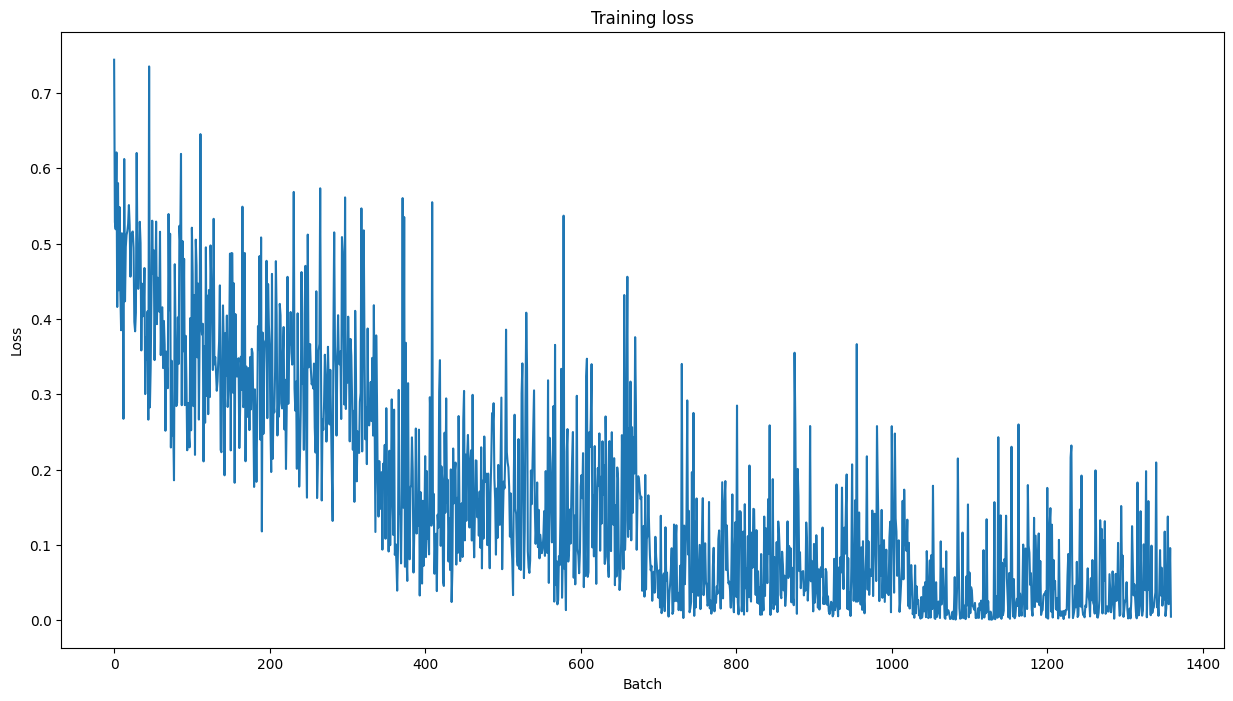

In [28]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [29]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None,
  names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values
# We need to add special tokens at the beginning and end of each sentence
# for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype ="long", truncating="post",padding ="post")

# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = \
  TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = \
  DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [30]:
# Prediction on the test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask , b_labels = batch
  # Telling the model not to compute or store gradients,
  # saving memory and speeding up prediction

  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to("cpu").numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [31]:
true_labels[2].dtype

dtype('int64')

In [32]:
pred = np.argmax(predictions[2], axis=1).flatten()

In [33]:
pred.dtype

dtype('int64')

In [34]:
# Evaluate Each Test Batch using f1_score

from sklearn.metrics import f1_score

f1_score_set = []

for i in range(len(true_labels)):

  true = true_labels[i]
  pred = np.argmax(predictions[i], axis=1).flatten()

  f1_sc = f1_score(true, pred, zero_division=1.0)

  f1_score_set.append(f1_sc)

f1_score_set

[0.72,
 0.76,
 0.7,
 0.7555555555555555,
 0.8260869565217391,
 0.9,
 0.9302325581395349,
 0.9642857142857143,
 0.9565217391304348,
 0.7894736842105262,
 0.8936170212765957,
 0.888888888888889,
 0.9268292682926829,
 0.9411764705882353,
 0.8627450980392156,
 0.7727272727272727,
 0.8571428571428571]

In [35]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

f1_score(flat_true_labels , flat_predictions)

0.8513513513513512

In [36]:
# source of the cell code: https://pytorch.org/tutorials/beginner/saving_loading_models.html

torch.save(model.state_dict(), 'bert-based-uncased-GED.pth')

In [37]:
# run on the custom sample dataset

model.eval()

df = pd.read_csv("Responses_Dataset.tsv", delimiter='\t')

# Create sentence and label lists
print(df.head())
sentences = df.Responses.values

# We need to add special tokens at the beginning and end of each sentence
# for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.labels.values
print(" sentence 1: ",sentences[0])
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

predictions = []
true_labels = []


# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype ="long", truncating="post",padding ="post")

# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 1

prediction_data = \
  TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = \
  DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Put model in evaluation mode
model.eval()

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask , b_labels = batch
  # Telling the model not to compute or store gradients,
  # saving memory and speeding up prediction

  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to("cpu").numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


                                           Responses  labels  \
0  One of the most common use is in market resear...       1   
1  The clustering technique can be used in multip...       1   
2  The main principle behind this method is that ...       1   
3  Feature engineering refer to developing some n...       0   
4  A hypothesis is a term that is generally used ...       1   

                                 Corrected_Responses  Unnamed: 3  Unnamed: 4  
0  One of the most common use is in market resear...         NaN         NaN  
1  The clustering technique can be used in multip...         NaN         NaN  
2  The main principle behind this method is that ...         NaN         NaN  
3  Feature engineering refers to developing some ...         NaN         NaN  
4  A hypothesis is a term that is generally used ...         NaN         NaN  
 sentence 1:  [CLS] One of the most common use is in market research and customer segmentation which is then utilized to target a particular 

In [38]:
flat_predictions

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [39]:
flat_true_labels

[1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0]

In [40]:

f1_score(flat_true_labels , flat_predictions)

0.7916666666666667